In [1]:
# Задание
# 1. скачать набор данных маркетинговых кампаний 
# отсюда https://www.kaggle.com/davinwijaya/customer-retention
# 2. там поле conversion - это целевая переменная, а offer - коммуникация. 
# Переименовать поля (conversion -> target, offer -> treatment) и 
# привести поле treatment к бинарному виду (1 или 0, т.е было какое-то 
# предложение или нет) - значение No Offer означает отсутствие коммуникации,
# а все остальные - наличие.
# 3. сделать разбиение набора данных не тренировочную и тестовую выборки
# 4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
# 5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner),
# модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
# 6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
# 7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
# 8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) 
# построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать 
# прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по
# uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого 
# дециля посчитать среднюю conversion
# 9. (опционально) построить модель UpliftRandomForestClassifier 
# и попытаться описать словами полученное дерево

In [2]:
#производим установку необхоимых компонентов
!pip install scikit-uplift
!pip install catboost
!pip install --upgrade pip
!pip install causalml

     |████████████████████████████████| 65.7MB 59kB/s 
     |████████████████████████████████| 1.5MB 6.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 235 kB 5.0 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |████████████████████████████████| 326 kB 37.6 MB/s 
     |████████████████████████████████| 1.8 MB 40.0 MB/s 
     |████████████████████████████████| 607 kB 46.0 MB/s 
     |████████████████████████████████| 394.7 MB 8.2 kB/s 
     |████████████████████████████████| 320.4 MB 12 kB/s 
     |████████████████████████████████| 459 kB 55.4 MB/s 
  Created wheel for causalml: filename=causalml-0.10.0-cp37-cp37m-linux_x86_64.whl size=493712 sha256=51a21942380cb532393fbe70a01b66b90b331acab0e5a79765720ef8e5270ed2
  Stored in directory: /root/.cache/pip/wheels/20/62/e4/1b01b29045cc20fcf5e5df417f93fd51fa21f2af233241e9a4
  Created wheel for shap: filename=shap

In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2, f_classif, SelectKBest, SelectPercentile


from sklift.models import SoloModel, ClassTransformation, TwoModels
from catboost import CatBoostClassifier
from sklift.metrics import uplift_at_k

In [4]:
# Загружаем данные для обработки

from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['data_mrk_uplift.csv']))


Saving data_mrk_uplift.csv to data_mrk_uplift.csv


In [5]:
# Смотрим первые строки
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [6]:
# Смотрим информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [7]:
# Смотрим стат описание данных
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Переименовываем поля (conversion -> target, offer -> treatment)

df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
# еще один вариант df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})


In [9]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [10]:
# Приводим поле treatment к бинарному виду
for val_name in list(set(df['treatment'].values.tolist())):
    if val_name == 'No Offer':
        df['treatment'] = df['treatment'].replace(val_name, 0)
    else:
        df['treatment'] = df['treatment'].replace(val_name, 1)


In [11]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [12]:
# Смотрим насколько сбалансирована наша целевая переменная
df["target"].value_counts()

0    54606
1     9394
Name: target, dtype: int64

In [13]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [14]:
# Балансировка целевой переменной

df_balanced = balance_df_by_target(df, "target")
    
df_balanced["target"].value_counts()

0    54606
1    46970
Name: target, dtype: int64

In [15]:
df=df_balanced

In [16]:
# Категоризация признаков

# функция для кодирования категориальных признаков

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def categor_features(df):
    df_non_numeric = df.select_dtypes(include='object')
    non_numeric_cols = df_non_numeric.columns.values

    #print(df[non_numeric_cols])

    for col in non_numeric_cols:
        df[col] = le.fit_transform(df[col])

In [17]:
categor_features(df)

In [18]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
99753,5,274.40,1,1,2,0,2,0,1
36871,1,522.40,1,0,2,1,1,0,0
77404,2,29.99,1,0,1,1,1,0,1
67864,10,279.57,1,0,0,1,2,0,1
3713,5,176.39,0,1,1,1,2,1,0


In [19]:
# Разбиваем набор данных на тренировочную и тестовую выборки
X_train_, X_test_= train_test_split(df, test_size=0.10, random_state=42)

In [20]:
indices_train = X_train_.index
indices_test = X_test_.index
indices_learn, indices_valid = train_test_split(X_train_.index, test_size=0.3, random_state=123)

In [21]:
X_train = df.loc[indices_learn, :]
y_train = X_train_.loc[indices_learn, 'target']
treat_train = X_train_.loc[indices_learn, 'treatment']

X_val = df.loc[indices_valid, :]
y_val = X_train_.loc[indices_valid, 'target']
treat_val =  X_train_.loc[indices_valid, 'treatment']

X_train_full = df.loc[indices_train, :]
y_train_full = X_train_.loc[:, 'target']
treat_train_full = X_train_.loc[:, 'treatment']

X_test = df.loc[indices_test, :]

X_train_tree = X_train

In [22]:
# Убираем "treatment" и "target" из набора признаков

X_train = X_train.drop(['treatment','target'], axis=1)
print(X_train.head(3))

       recency  history  used_discount  ...  zip_code  is_referral  channel
9891         3    99.85              0  ...         1            1        1
98822        5   378.68              1  ...         1            0        2
89161        8   472.16              1  ...         2            0        0

[3 rows x 7 columns]


In [23]:
# Отбираем верхние 75% признаков с наивысшими значениями стат показателя F
fval_sel = SelectPercentile(f_classif,percentile=75)
#fval_sel = SelectKBest(f_classif,k=6)
ftrs_kbest = fval_sel.fit_transform(X_train,y_train)

In [24]:
# Исходное количество признаков
X_train.shape[1]

7

In [25]:
# Сокращенное количество признаков
ftrs_kbest.shape[1]

5

In [26]:
X_train = ftrs_kbest

In [27]:
# определяем модели
treatment_model = CatBoostClassifier(iterations=50, thread_count=3,
                                     random_state=42, silent=True)
control_model = CatBoostClassifier(iterations=50, thread_count=3,
                                   random_state=42, silent=True)

# определяем метод
tm = TwoModels(treatment_model, control_model, method='vanilla')
# подгоняем модель
tm = tm.fit(X_train, y_train, treat_train)

# предсказываем uplift
uplift_preds = tm.predict(X_val)

In [28]:
# определяем метод
ct = ClassTransformation(CatBoostClassifier(verbose=100, random_state=777))
# подгоняем модель
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'plot': True})
# предсказываем uplift
uplift_ct = ct.predict(X_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  after removing the cwd from sys.path.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.060834
0:	learn: 0.6923957	total: 77.5ms	remaining: 1m 17s
100:	learn: 0.6829738	total: 2.51s	remaining: 22.3s
200:	learn: 0.6791754	total: 4.97s	remaining: 19.8s
300:	learn: 0.6744669	total: 7.54s	remaining: 17.5s
400:	learn: 0.6705632	total: 10.2s	remaining: 15.2s
500:	learn: 0.6668480	total: 12.8s	remaining: 12.7s
600:	learn: 0.6636200	total: 15.5s	remaining: 10.3s
700:	learn: 0.6604097	total: 18.1s	remaining: 7.74s
800:	learn: 0.6571250	total: 20.8s	remaining: 5.18s
900:	learn: 0.6542755	total: 23.6s	remaining: 2.59s
999:	learn: 0.6516464	total: 26.3s	remaining: 0us


In [29]:
sm = SoloModel(CatBoostClassifier(verbose=100, random_state=777))  # define approach
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'plot': True})  # fit the model
uplift_sm = sm.predict(X_val)  # predict uplift

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.060834
0:	learn: 0.6891425	total: 47.4ms	remaining: 47.4s
100:	learn: 0.6531169	total: 2.59s	remaining: 23.1s
200:	learn: 0.6472778	total: 5.13s	remaining: 20.4s
300:	learn: 0.6414429	total: 7.74s	remaining: 18s
400:	learn: 0.6359522	total: 10.4s	remaining: 15.6s
500:	learn: 0.6310320	total: 13.1s	remaining: 13s
600:	learn: 0.6266317	total: 15.9s	remaining: 10.5s
700:	learn: 0.6224202	total: 18.6s	remaining: 7.92s
800:	learn: 0.6185417	total: 21.2s	remaining: 5.28s
900:	learn: 0.6143844	total: 24s	remaining: 2.64s
999:	learn: 0.6108955	total: 26.9s	remaining: 0us


In [30]:
# Рассчитываем метрики

# Uplift@20%
tm_uplift_at_k_20 = uplift_at_k(y_true=y_val, uplift=uplift_preds, treatment=treat_val,
                             strategy='overall', k=0.2)
# Uplift@10%
tm_uplift_at_k_10 = uplift_at_k(y_true=y_val, uplift=uplift_preds, treatment=treat_val,
                             strategy='overall', k=0.1)
# Uplift@20%
ct_uplift_at_k_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val,
                             strategy='overall', k=0.2)
# Uplift@10%
ct_uplift_at_k_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val,
                             strategy='overall', k=0.1)
# Uplift@20%
sm_uplift_at_k_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val,
                             strategy='overall', k=0.2)
# Uplift@10%
sm_uplift_at_k_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val,
                             strategy='overall', k=0.1)


In [31]:
# Формируем результирующий датафрейм 
res_tbl = pd.DataFrame({'SoloModel': [f'{sm_uplift_at_k_20:.3f} ',
                                                  f'{sm_uplift_at_k_10:.3f} '],
                           'ClassTransformation': [f'{ct_uplift_at_k_20:.3f} ',
                                                  f'{ct_uplift_at_k_10:.3f} '],                       
                           'TwoModels': [f'{tm_uplift_at_k_20:.3f} ',
                                                  f'{tm_uplift_at_k_10:.3f} ']},
                          columns=["SoloModel", "ClassTransformation", "TwoModels"],
                          index=['Uplift@20%','Uplift@10%'])

In [32]:
res_tbl

,SoloModel,ClassTransformation,TwoModels
Uplift@20%,0.114,0.194,0.164
Uplift@10%,0.119,0.262,0.193


In [33]:
X_val_tree = X_val
features = [col for col in X_train_tree]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


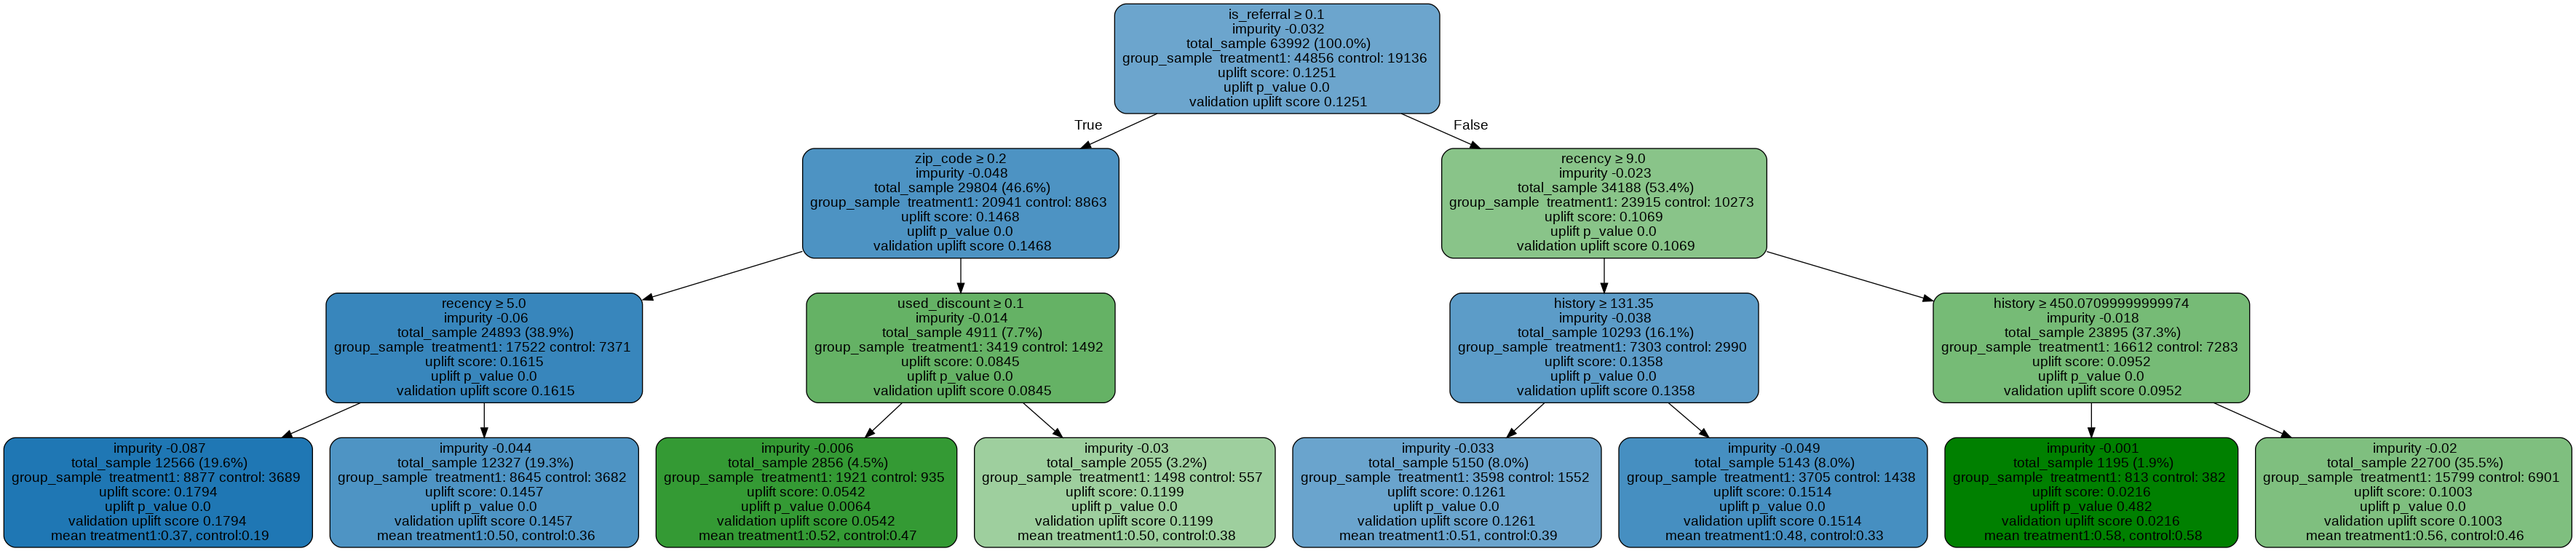

CPU times: user 3.21 s, sys: 313 ms, total: 3.52 s
Wall time: 5.85 s


In [34]:
%%time
from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))
